In [1]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('darkgrid')
%matplotlib inline

# Gathering Data

In [2]:
url = 'https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions'
html = requests.get(url).content
df_list = pd.read_html(html)
massivechanges = df_list[1]

In [3]:
priceoffutures = pd.read_csv('30-day-fed-funds-futures.csv')

# Cleaning & Processing

In [4]:
date_time_str = 'January 29, 2003'
date_time_obj = datetime.strptime(date_time_str, '%B %d, %Y')

In [5]:
date_time_obj

datetime.datetime(2003, 1, 29, 0, 0)

In [6]:
massivechanges['Converted_Datetime'] = massivechanges['Date'].apply(lambda x:datetime.strptime(x, '%B %d, %Y'))

In [7]:
del massivechanges['Votes']
del massivechanges['Date']
del massivechanges['Notes']
del massivechanges['Discount Rate']

In [8]:
massivechanges

,Fed. Funds Rate,Converted_Datetime
0,0%–0.25%,2020-03-15
1,1%–1.25%,2020-03-03
2,1.50%–1.75%,2019-10-30
3,1.75%–2.00%,2019-09-18
4,2.00%–2.25%,2019-07-31
...,...,...
61,1.25%,2003-05-06
62,1.25%,2003-03-18
63,1.25%,2003-01-29
64,1.25%,2003-01-09


In [9]:
priceoffutures['Date'] = priceoffutures['date'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y'))

In [10]:
del priceoffutures['date']

In [11]:
def parsestring(s):
    if chr(8211) in s:
        wow = s.split(chr(8211))
        s1 = wow[0][:-1]
        s2 = wow[1][:-1]
        return (float(s1) + float(s2)) / 2
    else:
        return float(s[:-1])

In [12]:
massivechanges['Rate'] = massivechanges['Fed. Funds Rate'].apply(parsestring)

In [13]:
del massivechanges['Fed. Funds Rate']

In [14]:
massivechanges

,Converted_Datetime,Rate
0,2020-03-15,0.125
1,2020-03-03,1.125
2,2019-10-30,1.625
3,2019-09-18,1.875
4,2019-07-31,2.125
...,...,...
61,2003-05-06,1.250
62,2003-03-18,1.250
63,2003-01-29,1.250
64,2003-01-09,1.250


In [15]:
priceoffutures_dict = {}
for i in range(priceoffutures.shape[0]):
    priceoffutures_dict[priceoffutures['Date'][i]] = priceoffutures[' value'][i]

In [16]:
massivechanges['DayofWeek'] = massivechanges['Converted_Datetime'].apply(lambda x : datetime.weekday(x))

In [17]:
priceoffutures


,value,Date
0,91.710,1988-10-03
1,91.710,1988-10-04
2,91.730,1988-10-05
3,91.700,1988-10-06
4,91.780,1988-10-07
...,...,...
8004,99.920,2020-07-23
8005,99.920,2020-07-24
8006,99.925,2020-07-27
8007,99.922,2020-07-28


In [18]:
def rowinpriceoffutures(i):
    for j in range(len(priceoffutures['Date'])):
        if priceoffutures['Date'][j] > i:
            return j-1
    return -1

In [19]:
massivechanges['rowinpriceoffutures'] = massivechanges['Converted_Datetime'].apply(lambda x : rowinpriceoffutures(x))

In [20]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
    if massivechanges['DayofWeek'][i] == 5 or massivechanges['DayofWeek'][i] == 6:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]])
    else:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]-1])

massivechanges['Day before'] = pd.Series(returnlist)


In [21]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]+1])

massivechanges['Day after'] = pd.Series(returnlist)

In [22]:
massivechanges['Ratedaybefore'] = massivechanges['Day before'].apply(lambda x : priceoffutures_dict[x])

In [23]:
massivechanges['Ratedayafter'] = massivechanges['Day after'].apply(lambda x : priceoffutures_dict[x])

In [24]:
massivechanges['difference'] = massivechanges['Ratedayafter'] - massivechanges['Ratedaybefore']

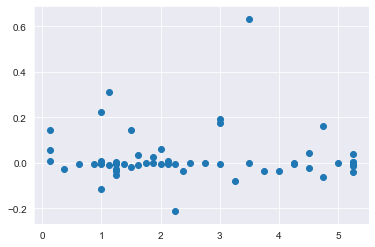

In [25]:
plt.scatter(massivechanges['Rate'], massivechanges['difference'])
plt.show()

/opt/anaconda3/envs/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


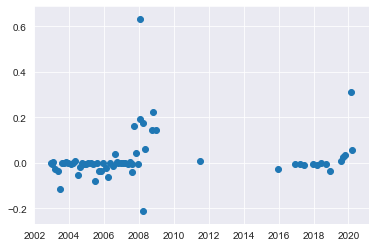

In [26]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['difference'])
plt.show()

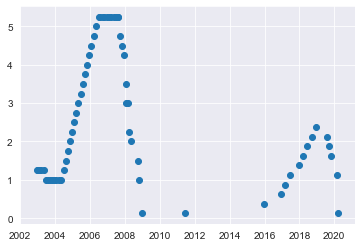

In [27]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['Rate'])
plt.show()

In [28]:
returnlist = []
for i in range(len(massivechanges['Rate'])):
    if i == len(massivechanges['Rate'])-1:
        returnlist.append(0)
    else:
        returnlist.append(massivechanges['Rate'][i] - massivechanges['Rate'][i+1])
massivechanges['Rate Changes'] = pd.Series(returnlist)

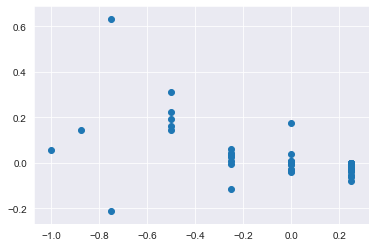

In [29]:
plt.scatter(massivechanges['Rate Changes'], massivechanges['difference'])
plt.show()

In [30]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50
2,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25
3,2019-09-18,1.875,2,7791,2019-09-17,2019-09-19,98.095,98.1200,0.0250,-0.25
4,2019-07-31,2.125,2,7757,2019-07-30,2019-08-01,97.930,97.9400,0.0100,-0.25
...,...,...,...,...,...,...,...,...,...,...
61,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00
62,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00
63,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00
64,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00


# Figures

## Rate change on difference (before - after)

In [32]:
x = massivechanges['Rate Changes']
y = massivechanges['difference']
xVal, yVal = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(x, y) if xVal==a])) for xVal in set(x)))

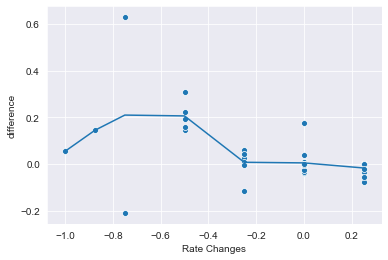

In [33]:
sns.lineplot(x=xVal, y=yVal)
sns.scatterplot(x='Rate Changes', y='difference', data=massivechanges)

In [34]:
x_np = (massivechanges['Rate Changes']).to_numpy()
y_np = massivechanges['difference'].to_numpy()

In [35]:
m, b = np.polyfit(x_np, y_np, 1)

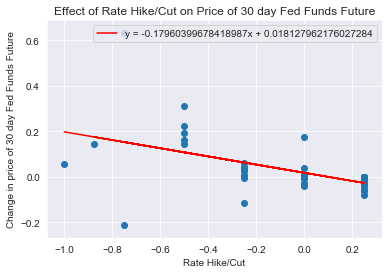

In [36]:
plt.scatter(x, y)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.xlabel("Rate Hike/Cut")
plt.ylabel("Change in price of 30 day Fed Funds Future")
plt.title("Effect of Rate Hike/Cut on Price of 30 day Fed Funds Future")
plt.legend()

plt.savefig('rate_change_on_FFF.png', dpi=800)

In [37]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50
2,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25
3,2019-09-18,1.875,2,7791,2019-09-17,2019-09-19,98.095,98.1200,0.0250,-0.25
4,2019-07-31,2.125,2,7757,2019-07-30,2019-08-01,97.930,97.9400,0.0100,-0.25
...,...,...,...,...,...,...,...,...,...,...
61,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00
62,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00
63,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00
64,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00


## difference (before - before) on Rate Change

In [38]:
retList = []
for i in range(len(massivechanges['Ratedaybefore'])):
    if i == len(massivechanges['Ratedaybefore'])-1:
        retList.append(0)
    else:
        retList.append(massivechanges['Ratedaybefore'][i+1] - massivechanges['Ratedaybefore'][i])
massivechanges['difference type 2'] = pd.Series(retList)

In [39]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes,difference type 2
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00,-0.930
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50,-0.503
2,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25,-0.312
3,2019-09-18,1.875,2,7791,2019-09-17,2019-09-19,98.095,98.1200,0.0250,-0.25,-0.165
4,2019-07-31,2.125,2,7757,2019-07-30,2019-08-01,97.930,97.9400,0.0100,-0.25,-0.300
...,...,...,...,...,...,...,...,...,...,...,...
61,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00,0.005
62,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00,-0.050
63,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00,-0.005
64,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00,-0.010


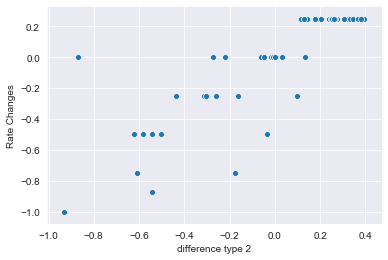

In [40]:
sns.scatterplot(x='difference type 2', y='Rate Changes', data=massivechanges)

In [41]:
x_np = (massivechanges['difference type 2']).to_numpy()
y_np = massivechanges['Rate Changes'].to_numpy()

In [42]:
m, b = np.polyfit(x_np, y_np, 1)

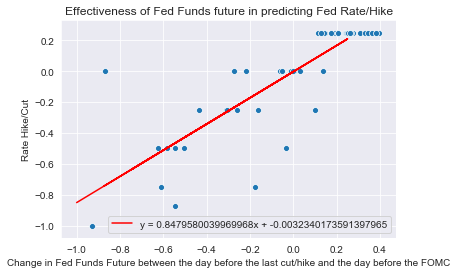

In [43]:
sns.scatterplot(x='difference type 2', y='Rate Changes', data=massivechanges)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.xlabel("Change in Fed Funds Future between the day before the last cut/hike and the day before the FOMC")
plt.ylabel("Rate Hike/Cut")
plt.title("Effectiveness of Fed Funds future in predicting Fed Rate/Hike")
plt.legend()

plt.savefig('FFF_on_rate_change.png', dpi=800)

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_np, y_np)
print(slope)
print(intercept)
print(r_value ** 2)
print(p_value)

0.8479580039969967
-0.0032340173591397896
0.7104725259831407
6.963223645893072e-19


## Rate change on difference (after - after)

In [45]:
retList = []
for i in range(len(massivechanges['Ratedayafter'])):
    if i == len(massivechanges['Ratedayafter'])-1:
        retList.append(0)
    else:
        retList.append(massivechanges['Ratedayafter'][i+1] - massivechanges['Ratedayafter'][i])
massivechanges['difference type 3'] = pd.Series(retList)

In [46]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes,difference type 2,difference type 3
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00,-0.930,-0.6750
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50,-0.503,-0.7775
2,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25,-0.312,-0.3225
3,2019-09-18,1.875,2,7791,2019-09-17,2019-09-19,98.095,98.1200,0.0250,-0.25,-0.165,-0.1800
4,2019-07-31,2.125,2,7757,2019-07-30,2019-08-01,97.930,97.9400,0.0100,-0.25,-0.300,-0.3450
...,...,...,...,...,...,...,...,...,...,...,...,...
61,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00,0.005,0.0150
62,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00,-0.050,-0.0230
63,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00,-0.005,-0.0120
64,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00,-0.010,-0.0050


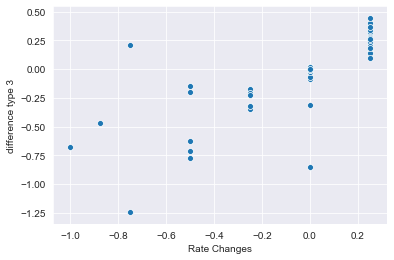

In [48]:
sns.scatterplot(x='Rate Changes', y='difference type 3', data=massivechanges)

In [49]:
x_np = massivechanges['Rate Changes'].to_numpy()
y_np = (massivechanges['difference type 3']).to_numpy()

In [50]:
m, b = np.polyfit(x_np, y_np, 1)

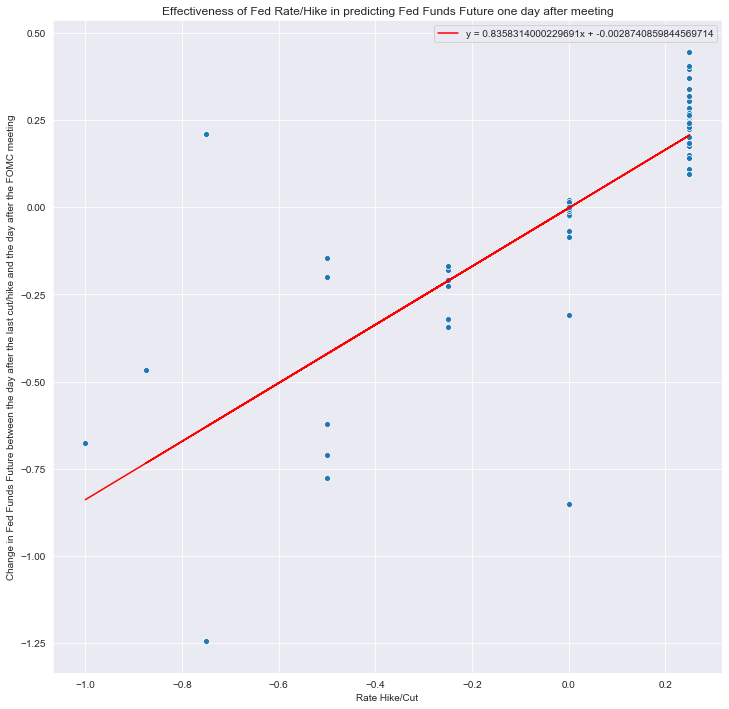

In [55]:
fig = plt.figure(figsize=(12, 12))

sns.scatterplot(x='Rate Changes', y='difference type 3', data=massivechanges)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.ylabel("Change in Fed Funds Future between the day after the last cut/hike and the day after the FOMC meeting")
plt.xlabel("Rate Hike/Cut")
plt.title("Effectiveness of Fed Rate/Hike in predicting Fed Funds Future one day after meeting")
plt.legend()

# plt.savefig('rate_change_on_FFF_2.png', dpi=800)

In [52]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_np, y_np)
print(slope)
print(intercept)
print(r_value ** 2)
print(p_value)

0.8358314000229691
-0.002874085984456898
0.6161369183162223
6.193669579818441e-15
